In [111]:
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import thermo.unifac
from scipy.integrate import quad
from scipy import optimize
from chemicals import search_chemical, CAS_from_any
from thermo import ChemicalConstantsPackage, CEOSGas, IdealGas, CEOSLiquid, PRMIX, SRKMIX, IGMIX, FlashVL, HeatCapacityGas
from thermo.interaction_parameters import IPDB
from thermo.unifac import UFIP, UFSG, UNIFAC
from thermo.phase_change import EnthalpyVaporization, EnthalpySublimation
thermo.unifac.load_group_assignments_DDBST()
%matplotlib inline

In [112]:
#Pxy diagram
def Pxy(a,b,T, compare = True):
    constants, properties = ChemicalConstantsPackage.from_IDs([a, b])
    kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')
    
    eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs, 'omegas': constants.omegas, 'kijs': kijs}
    gas = CEOSGas(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
    liquid = CEOSLiquid(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
    flasher = FlashVL(constants, properties, liquid=liquid, gas=gas)
    
    x = np.array(np.linspace(0, 1, 500))
    Px = np.array(np.linspace(0, 1, 500))
    i = 0
    while i < 500:
        zs = [x[i],1-x[i]]
        Px[i] = flasher.flash(T=T, VF=1, zs=zs).P
        i += 1
        
    y = np.array(np.linspace(0, 1, 500))
    Py = np.array(np.linspace(0, 1, 500))
    i = 0
    while i < 500:
        zs = [y[i],1-y[i]]
        Py[i] = flasher.flash(T=T, VF=0, zs=zs).P
        i += 1
    
    #plot Pxy diagram 
    plt.figure(figsize=(8,8))
    Px_theo = plt.plot(x, Px/1000, color = 'blue', label = 'PR EOS + Van der Waals mixing rules')
    Py_theo = plt.plot(y, Py/1000, color = 'blue')
    
    #compare with experimental data (available only for T=260 K)
    if compare == True:
        if a == 'propane' and b == 'isobutane' and T == 260:
            x_exp = [0.3410, 0.47700, 0.6078, 0.8030, 0.8778]
            y_exp = [0.6172, 0.7440, 0.8299, 0.9175, 0.9555]
            P_exp = [161.2, 190.6, 218.1, 259.6, 276.3]
            Px_exp = plt.plot(x_exp, P_exp, 'o', color = 'red', label = 'Experimental data')
            Py_exp = plt.plot(y_exp, P_exp, 'o', color = 'red')
    
    plt.grid
    plt.title("P-xy diagram for " + str(a) + "-" + str(b) + " at " + str(T) + " K")
    plt.ylabel("Pressure, kPa")
    plt.xlabel("Composition, mol frac. " + str(a))
    plt.legend()
    Pxy = plt.show()
    return Pxy

#Txy data


#Txy diagram
def Txy(a,b,P, compare = True):
    constants, properties = ChemicalConstantsPackage.from_IDs([a, b])
    kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')
    eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs, 'omegas': constants.omegas, 'kijs': kijs}
    gas = CEOSGas(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
    liquid = CEOSLiquid(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
    flasher = FlashVL(constants, properties, liquid=liquid, gas=gas)
    
    x = np.array(np.linspace(0, 1, 20))
    ye = np.array(np.linspace(0, 1, 20))
    T = np.array(np.linspace(0, 1, 20))
    i = 0
    while i < 20:
        zs = [x[i],1-x[i]]
        ye0 = flasher.flash(P=P*1000, VF=0, zs=zs).gas.zs
        ye[i] = ye0[0]
        T[i] = flasher.flash(P=P*1000, VF=0, zs=zs).T
        i += 1
        
    #plot Txy diagram 
    fig, ax = plt.subplots(2, figsize=(8,12.5))
    Tx_theo = ax[0].plot(x, T, color = 'blue', label = 'PR EOS + Van der Waals mixing rules')
    Ty_theo = ax[0].plot(ye, T, color = 'blue')
    ax[1].plot(x, ye, color = 'blue', label = 'PR EOS + Van der Waals mixing rules')
    line45 = ax[1].plot(x,x)
    
    #compare with other methods
    if compare == True:
        if a == 'acetone' and b == 'methanol':
            x_exp = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
            y_exp = [0, 0.102, 0.186, 0.322, 0.428, 0.513, 0.586, 0.656, 0.725, 0.8, 1.0]
            T_exp = np.array([64.5, 63.6, 62.5, 60.2, 58.65, 57.55, 56.7, 56, 55.3, 55.05, 56.1])+273.15
            Tx_exp = ax[0].plot(x_exp, T_exp, 'o', color = 'red')
            Ty_exp = ax[0].plot(y_exp, T_exp, 'o', color = 'red')
            xy_exp = ax[1].plot(x_exp, y_exp, 'o', color = 'red')

        elif a == 'benzene' and b == 'toluene':
            x_exp = [1., 0.780, 0.581, 0.411, 0.258, 0.130, 0]
            y_exp = [1., 0.9, 0.777, 0.632, 0.456, 0.261, 0]
            T_exp = [353.3, 358.2, 363.2, 368.2, 373.2, 378.2, 383.8]
            Tx_exp = ax[0].plot(x_exp, T_exp, 'o', color = 'red', label = 'Raoults law')
            Ty_exp = ax[0].plot(y_exp, T_exp, 'o', color = 'red')
            xy_exp = ax[1].plot(x_exp, y_exp, 'o', color = 'red', label = 'Raoults law')

        elif a == 'propane' and b == 'isobutane' and P == 101.325:
            x_exp1 = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
                     0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
            x_exp2 = [0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 
                      0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.68421, 
                      0.736842, 0.789474, 0.842105, 0.894737, 0.947368, 1]
            y_exp1 = [0, 0.145951024, 0.267880268, 0.370653031, 0.457994384, 
                     0.532786496, 0.597281926, 0.65325817, 0.702130704, 0.745036495, 
                     0.782896301, 0.816461535, 0.846349885, 0.873072607, 0.897055594, 
                     0.918655801, 0.938174122, 0.955865575, 0.971947405, 0.986605575, 1.000000003]
            y_exp2 = [0, 0.142227, 0.263235, 0.366677, 0.455529, 0.53222, 0.59873, 0.656674, 0.707379, 
                      0.751936, 0.791245, 0.826054, 0.856986, 0.884564, 0.909225, 0.931342, 0.951228, 
                      0.969152, 0.985344, 1]
            T_exp1 = [261.2402381, 258.5501302, 256.0817859, 253.8078615, 251.7051268, 
                     249.7537866, 247.9369112, 246.2399659, 244.6504208, 243.1574298, 
                     241.7515659, 240.4246013, 239.1693269, 237.979401, 236.8492247, 
                     235.7738365, 234.7488246, 233.7702528, 232.8345982, 231.9386981, 231.0797046]
            T_exp2 = [261.273, 258.64, 256.186, 253.897, 251.757, 249.754, 247.876, 246.112, 244.452, 
                      242.887, 241.409, 240.01, 238.686, 237.429, 236.235, 235.099, 234.017, 232.986, 
                      232.001, 231.061]
            Tx_exp1 = ax[0].plot(x_exp1, T_exp1, '--', color = 'red', label = 'Raoults law')
            Tx_exp2 = ax[0].plot(x_exp2, T_exp2, linestyle = 'dotted', color = 'green', label = 'SRK + UNIFAC')
            Ty_exp1 = ax[0].plot(y_exp1, T_exp1, '--', color = 'red')
            Ty_exp2 = ax[0].plot(y_exp2, T_exp2, linestyle = 'dotted', color = 'green')
            xy_exp1 = ax[1].plot(x_exp1, y_exp1, '--', color = 'red', label = 'Raoults law')
            xy_exp2 = ax[1].plot(x_exp2, y_exp2, linestyle = 'dotted', color = 'green', label = 'SRK + UNIFAC')
            
    ax[0].set_title("y-x diagram for " + str(a) + "-" + str(b) + " at " + str(P) + " kPa")
    ax[0].grid
    ax[0].legend()
    ax[0].set_ylabel("Temperature, K")
    ax[0].set_xlabel("Composition, mol frac. " + str(a))
    
    ax[1].set_title("T-xy diagram for " + str(a) + "-" + str(b) + " at " + str(P) + " kPa")
    ax[1].grid
    ax[1].legend()
    ax[1].set_ylabel("Vapor composition, mol frac. " + str(a))
    ax[1].set_xlabel("Liquid composition, mol frac. " + str(a))
    return(x, ye, T, fig)

def Hxy(a, b, P, plot = False, compare = False):
    constants, properties = ChemicalConstantsPackage.from_IDs([a, b])
    kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')
    a_Hvap = EnthalpyVaporization(CAS_from_any(a), Tb=constants.Tbs[0], Tc=constants.Tcs[0], Pc=constants.Pcs[0], omega=constants.omegas[0], 
                     similarity_variable=None, Psat=None, Zl=None, Zg=None, extrapolation='Watson')
    b_Hvap = EnthalpyVaporization(CAS_from_any(b), Tb=constants.Tbs[1], Tc=constants.Tcs[1], Pc=constants.Pcs[1], omega=constants.omegas[1], 
                     similarity_variable=None, Psat=None, Zl=None, Zg=None, extrapolation='Watson')
    
    eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs, 'omegas': constants.omegas, 'kijs': kijs}
    gas = CEOSGas(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
    liquid = CEOSLiquid(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
    flasher = FlashVL(constants, properties, liquid=liquid, gas=gas)
    
    x = np.array(np.linspace(0, 1, 20))
    ye = np.array(np.linspace(0, 1, 20))
    T = np.array(np.linspace(0, 1, 20))
    Hy = np.array(np.linspace(0, 1, 20))
    hx = np.array(np.linspace(0, 1, 20))
    Hy1 = np.array(np.linspace(0, 1, 20))
    hx1 = np.array(np.linspace(0, 1, 20))
    i = 0
    while i < 20:
        zs = [x[i],1-x[i]]
        ye0 = flasher.flash(P=P*1000, VF=0, zs=zs).gas.zs
        ye[i] = ye0[0]
        T[i] = flasher.flash(P=P*1000, VF=0, zs=zs).T
        Hy[i] = flasher.flash(P=P*1000, VF=0, zs=zs).gas.H()
        hx[i] = flasher.flash(P=P*1000, VF=0, zs=zs).liquid0.H()
        
        if compare == True:
            gas2 = CEOSGas(eos_class=IGMIX, eos_kwargs=eos_kwargs, T=T[i], P=P*1000, 
                           zs=[ye[i],1-ye[i]], HeatCapacityGases=properties.HeatCapacityGases)
            liquid2 = CEOSLiquid(eos_class=IGMIX, eos_kwargs=eos_kwargs, T=T[i], P=P*1000, 
                                 zs=[x[i],1-x[i]], HeatCapacityGases=properties.HeatCapacityGases)
            Hy1[i] = gas2.H() + (ye[i]*a_Hvap(T[i])) + ((1-ye[i])*b_Hvap(T[i]))
            hx1[i] = liquid2.H()
        i += 1
    
    #plot Hxy diagram
    if plot == True:
        plt.figure(figsize = (8,12))
        plt.plot(x, hx, color = 'blue', label = 'PR EOS (with departure functions)')
        plt.plot(ye, Hy, color = 'blue')
        plt.title('Enthalpy-concentration diagram for ' + str(a) + '-' + str(b) + ' at ' + str(P) + ' kPa')
        plt.xlabel('Concentration, mole frac. ' + str(a))
        plt.ylabel('Enthalpy, kJ/kmol')
        plt.grid()
        
        if compare == True and plot == True:
            plt.plot(x, hx1, color = 'red', label = 'Ideal')
            plt.plot(ye, Hy1, color = 'red')
            plt.legend()
    return x, ye, hx, Hy

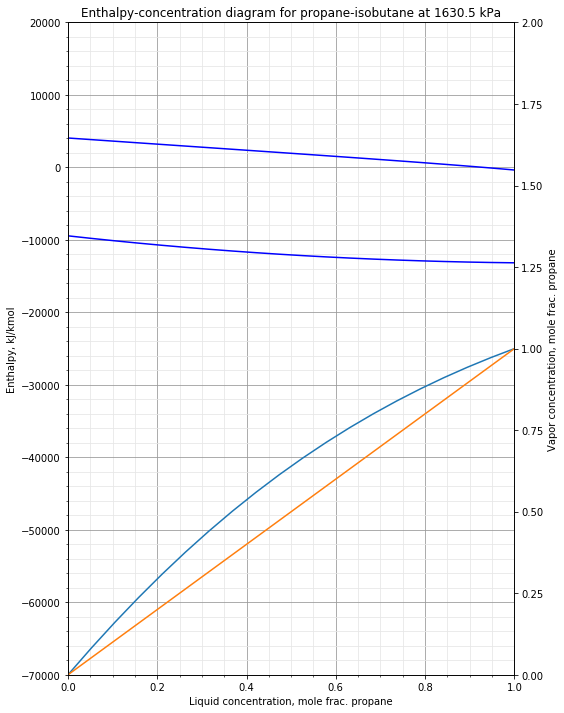

In [113]:
a = 'propane' #SET THE TWO COMPONENTS HERE
b = 'isobutane'
P = 1630.5 #SET PRESSURE

x, ye, hx, Hy = Hxy(a, b, P) #Hxy function returns vle data (xye-data + enthalpy)

#plot data; you have to adjust it here, manually
plt.figure(figsize = (8,12))
plt.plot(x, hx, color = 'blue')
plt.plot(ye, Hy, color = 'blue')
plt.title('Enthalpy-concentration diagram for ' + str(a) + '-' + str(b) + ' at ' + str(P) + ' kPa')
plt.xlabel('Liquid concentration, mole frac. ' + str(a))
plt.ylabel('Enthalpy, kJ/kmol')
plt.grid()
plt.xlim([0,1])
plt.ylim([-70000,20000])
plt.minorticks_on()
plt.grid(which='major', axis='both', linestyle='-', color='0.60')
plt.grid(which='minor', axis='both', linestyle='-', color='0.90')

ax = plt.twinx()
ax.set_ylim([0,2])
ax.set_ylabel('Vapor concentration, mole frac. ' + str(a))
ax.plot(x,ye)
ax.plot(x,x)
#plt.savefig('Ponchon-Savarit diagram propne+isobutane.pdf', dpi=300) #save pdf

#write data to spreadsheet
wb = openpyxl.Workbook()
ws = wb.active
i = 0
while i < 20:
    c1 = ws.cell(row = i+1, column = 1)
    c2 = ws.cell(row = i+1, column = 2)
    c3 = ws.cell(row = i+1, column = 3)
    c4 = ws.cell(row = i+1, column = 4)
    
    c1.value = x[i]
    c2.value = hx[i]
    c3.value = ye[i]
    c4.value = Hy[i]
    i += 1
    
wb.save('enthalpy-conc data propane-isobutane.xlsx') #save spreadsheet

#### NOTE 1: 
VLE data and enthalpies both depend on pressure, so a different pressure means a different diagram.

#### NOTE 2 (take this with a grain of salt coz' I haven't tested this yet): 
Residual enthalpies were taken into account

$$H^R \equiv H-H^{ig} = -RT^2\int_{0}^{P}\left(\frac{\partial Z}{\partial T}\right)_P\frac{dP}{P}$$ 

consequently, for a fixed pressure, the enthalpy diagram is translated further down (away from the enthalpy diagram corresponding to the ideal state). But the shape of the curves don't change; no shrinking, rotation, etc., So, if you're just going to use the enthalpy-concentration data for the Ponchon-Savarit diagram, it really doesn't matter whether or not you add the residuals. I just added it there to be consistent with the thermodynamic basis I used to obtain the VLE data.

In [115]:
a = 'propane'
b = 'isobutane'
xD = [0.957, 0.043]
xF = [0.109, 0.891]
xB = [0.088, 0.912]

constants, properties = ChemicalConstantsPackage.from_IDs([a, b])
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')
eos_kwargs = {'Pcs': constants.Pcs, 'Tcs': constants.Tcs, 'omegas': constants.omegas, 'kijs': kijs}
gas = CEOSGas(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liquid = CEOSLiquid(PRMIX, eos_kwargs=eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flasher = FlashVL(constants, properties, liquid=liquid, gas=gas)

T = 273.15 + (120-32)/1.8

#Column pressure
PD = flasher.flash(zs=xD, T=T, VF=0).P/1000
if PD < 1480:
    print('Use total condenser (reset PD to 206.843 kPa if PD < 206.843 kPa)')
else:
    PD = flasher.flash(zs=xD, T=T, VF=1).P/1000
    if PD < 2520:
        print('Distillate pressure: ' + str(PD) + ' kPa')
        PB = PD + 14 + 35
        TB = flasher.flash(zs=xB, P=PB, VF=0).T
        if TB > constants.Tcs[1]: #critical temp of LVC
            print('Lower pressure PB appropriately and recompute PD and TD')
        else:
            print('Bottoms pressure: ' + str(PB) + ' kPa')
        print('Use partial condenser')
        print(' ')
        
#Flash the feed; PB must be available for the code to work
F = 206.83 #kmol/h
TF0 = 273.15 + (171-32)/1.8
PF0 = 1647.85
PF1 = (PB + PD)/2

def Qfunct(T): #column pressure, and feed comp. and temp. must be fixed for code to work
    feed0 = flasher.flash(zs=xF, P=PF0, T=TF0)
    feed1 = flasher.flash(zs=xF, P=PF1, T=T)
    return np.absolute(feed1.H()-feed0.H())

TF1 = optimize.newton(Qfunct, TF0, fprime=None, args=(), tol=1.48e-08, maxiter=50, 
                fprime2=None, x1=None, rtol=0.0, full_output=False, disp=True)
q = flasher.flash(zs=xF, P=PF1, T=TF1).VF

print('Feed flowrate: ' + str(F) + ' kmol/h')
print('Feed composition: ' + str(xF))
print('Feed temperature: ' + str(TF1) + ' K')
print('Feed pressure: ' + str(PF1) + ' kPa')
print('Liquid fraction (q): ' + str(1-q))


Distillate pressure: 1578.740306693651 kPa
Bottoms pressure: 1627.740306693651 kPa
Use partial condenser
 
Feed flowrate: 206.83 kmol/h
Feed composition: [0.109, 0.891]
Feed temperature: 350.37169831078387 K
Feed pressure: 1603.240306693651 kPa
Liquid fraction (q): 0.0
